In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import napari
import os
from skimage import io
import pickle
from matplotlib import pyplot as plt
from scipy import interpolate
from scipy import spatial
from scipy import stats

import importlib
import morphotrack.points
import morphotrack.align
import morphotrack.nonlinear_align
import morphotrack.track
import morphotrack.image
import morphotrack.distance
importlib.reload(morphotrack.image)

import seaborn as sns
import pandas as pd

from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [2]:
sns.set(font_scale = 1.3)
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':['Arial']})
sns.set_style("ticks")

## load data and preprocess

In [3]:
# read tracks
tracks_original = {
    'track_00':xr.open_dataset('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/track_ds.nc').load(),
    'track_01':xr.open_dataset('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/track_ds.nc').load(),
    'track_02':xr.open_dataset('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/track_ds.nc').load(),
    'track_v2':xr.open_dataset('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/track_ds_fft.nc').load(),
}

# read cell coordinates
cell_coords = {
    'track_00':pd.read_csv('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/coord_centroids.csv',index_col=0),
    'track_01':pd.read_csv('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
    'track_02':pd.read_csv('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
    'track_v2':pd.read_csv('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/R02_R01/R02ch488_to_R01_segmentation/coord_centroids.csv',index_col=0),
}

# load images for visualization
image_set = {
    'track_00':[io.imread('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/R01_ch488_10um.tif'),
               io.imread('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/R01_ch561_10um.tif')],
    'track_01':[io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R02_ch488_10um.tif'),
               io.imread('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/R01_ch561_10um.tif')],
    'track_02':[io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R02_ch488_10um.tif'),
               io.imread('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/R01_ch561_10um.tif')],
    'track_v2':[io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R02_ch488_10um.tif'),
               io.imread('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/R01_ch561_10um.tif')],
}

# output layer_info path
layer_info_path = {
    'track_00':'/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/layer_info.nc',
    'track_01':'/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/layer_info.nc',
    'track_02':'/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/layer_info.nc',
    'track_v2':'/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/layer_info.nc',
}

In [5]:
# selection of the tracks
selection_set = {
    'track_00':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/filter_da.nc').load().all(axis=0),
    'track_01':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/filter_da.nc').load().all(axis=0),
    'track_02':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/filter_da.nc').load().all(axis=0),
    'track_v2':xr.open_dataarray('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/filter_da_fft.nc').load().all(axis=0)
}

tracks = {}
for key in tracks_original:
    track_selection = selection_set[key].track[selection_set[key].data]
    track_ds = tracks_original[key].sel(track=track_selection.data)
    tracks[key] = track_ds

## analysis 

In [6]:
def norm_1d(vector):
    return vector / np.linalg.norm(vector)

def get_unique_number(list_of_array):
    if len(list_of_array) == 0:
        sequence = np.empty(0, dtype=np.int64)
    else:
        sequence = np.concatenate(list_of_array, axis=0)
        sequence = sequence.astype(np.int64)
    unique_number = np.unique(sequence)
    return unique_number

In [7]:
track_set = 'track_v2'
track_ds = tracks[track_set]

scaling_factor = np.asarray([3,0.65,0.65])
cells = cell_coords[track_set].loc[:,['centroid-0','centroid-1','centroid-2']] * scaling_factor / 10# convert unit to 10 um for consistency
cells = cells.to_numpy()

# build kdtree from cellular coordinates
coords_tree = spatial.KDTree(cells)

In [8]:
viewer = napari.Viewer()
viewer.add_image(track_ds.Total_warped)

<Image layer 'Image' at 0x7f657d5cbb20>

In [9]:
# manual determine the position of the layer in d' space
l_pos = np.asarray([0,50,118,205,235])
layers = ['layer12', 'layer3', 'layer456', 'wm']
layer_position = {}
for i, p in enumerate(l_pos[:-1]):
    layer_position[layers[i]] = slice(l_pos[i],l_pos[i+1])

In [10]:
# create dataarray to save the cell counts and the layer thickness
layer_position_da = xr.DataArray(np.asarray([[i.start, i.stop] for i in layer_position.values()]),
                   coords={'layer': layers, 'slice':['start','stop']},
                   dims=['layer', 'slice']
                   )

layer_counts = xr.DataArray(np.nan,
                   coords={'track': track_ds.track,
                           'layer': layers
                          },
                   dims=['track', 'layer']
                   ).astype(float)

layer_thickness = xr.DataArray(np.nan,
                   coords={'track': track_ds.track,
                           'layer': layers
                          },
                   dims=['track', 'layer']
                   ).astype(float)

In [11]:
# parameters
half_thickness = 2.5
radius = 10

# calculation
for tr in tqdm(track_ds.track.data):
    for layer in layers:
        warped_pos = track_ds.Warped_position.rename({'warped_time':'time'}).sel(track=tr)
        warped_pos = warped_pos.isel(time=layer_position[layer])
        # flow calculation
        flow = warped_pos.copy()
        flow_temp = flow.diff(dim='time')
        flow[dict(time=slice(1,None))] = flow_temp
        flow[dict(time=0)] = flow.isel(time=1)
        # normalize flow
        flow = xr.apply_ufunc(
            norm_1d,
            flow,
            input_core_dims=[["space"]],
            output_core_dims=[["space"]],
            vectorize=True,
        ) # xr.apply_ufunc may be slow in this usage.
        flow = flow.fillna(0)

        _, idx, _ = morphotrack.points.count_around_position(warped_pos.data, flow.data, coords_tree, half_thickness, radius)

        uni_idx = get_unique_number(idx)


        # add to xarray
        layer_counts.loc[dict(track=tr,layer=layer)] = uni_idx.size
        layer_thickness.loc[dict(track=tr,layer=layer)] = morphotrack.distance.position2distance(warped_pos.data).sum()

  0%|                                                                                                     | 0/1470 [00:00<?, ?it/s]/tmp/ipykernel_1155778/442708152.py:2: RuntimeWarning: invalid value encountered in true_divide
  return vector / np.linalg.norm(vector)
100%|██████████████████████████████████████████████████████████████████████████████████████████| 1470/1470 [01:29<00:00, 16.34it/s]


In [12]:
# make dataset and save as xarray
layer_infos = xr.Dataset(data_vars={'Positions': layer_position_da, 'Counts': layer_counts, 'Thickness': layer_thickness})
layer_infos.to_netcdf(layer_info_path[track_set])

## Volume-flux analysis

In [13]:
layer_infos = {
    'track_00':xr.open_dataset('/mnt/ampa_data01/tmurakami/220305_SMA_nuc_middlehuman/morphotrack/layer_info.nc').load(),
    'track_01':xr.open_dataset('/mnt/ampa_data01/tmurakami/220615_slc17a7_nuc_sma_human_03/morphotrack/layer_info.nc').load(),
    'track_02':xr.open_dataset('/mnt/ampa_data01/tmurakami/220715_prefrontal_q1_R01/morphotrack/layer_info.nc').load(),
    'track_v2':xr.open_dataset('/mnt/ampa_data01/tmurakami/220806_visual_02_R01/morphotrack/layer_info.nc').load(),
}

In [14]:
color_dict = {
    'track_00':'#b1eba7',
    'track_01':'#5dfa41',
    'track_02':'#148700',
    'track_v2':'#a72ef2',
}

## Visualization of count, thickness (and density)

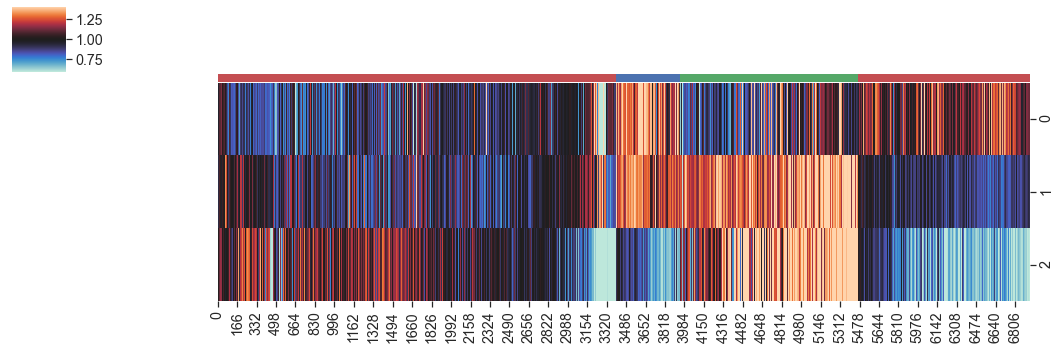

In [15]:
# in a heatmap
col_counts = xr.concat(layer_infos.values(),dim='track').Counts # / (xr.concat(layer_infos.values(),dim='track').Thickness ** 1)
col_counts = col_counts.sel(layer=['layer12', 'layer3', 'layer456'])

map_colors = np.zeros(col_counts.track.size)
pos = np.cumsum([0]+[i.track.size for i in layer_infos.values()])
for j, k in enumerate(pos[:-1]):
    map_colors[slice(pos[j],pos[j+1])]=j
lut = dict(zip(np.unique(map_colors), "rbgr"))
map_colors = np.vectorize(lut.get)(map_colors)

norm_layer_counts = col_counts / col_counts.median(dim='track')
# sns.heatmap((layer_counts.data / layer_thickness.data).T[1:,:])
vmin = 0.6# norm_layer_counts.quantile(0.05)
vmax = 1.4#norm_layer_counts.quantile(0.95)
sns.clustermap(norm_layer_counts.data.T, row_cluster=False, col_cluster=False, vmin=vmin, vmax=vmax, col_colors=map_colors, figsize=(15, 5),cmap="icefire")

2402.8 6178.0


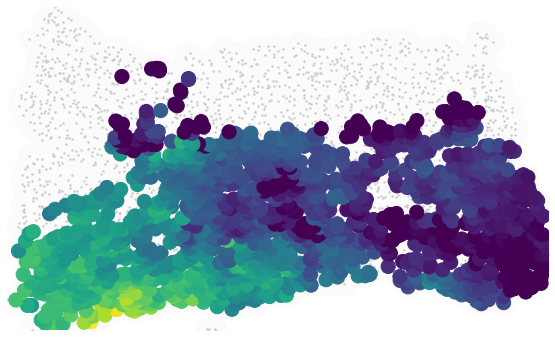

In [16]:
# in a flattened surface
track_set = 'track_v2'
layer = 'layer456'

# get values
X0 = tracks_original[track_set].Seeds.data
isomap = Isomap(n_neighbors=20, n_components=2, n_jobs=-1)
isomap.fit(X0)
manifold0 = isomap.transform(X0)
X1 = tracks[track_set].Seeds.data
manifold1 = isomap.transform(X1)

# thickness or countss
val = layer_infos[track_set].Counts.sel(layer=[layer]).copy()
val = val.data.squeeze()

# normalize for visualization
col_counts = xr.concat(layer_infos.values(),dim='track').Counts # / (xr.concat(layer_infos.values(),dim='track').Thickness ** 1)
# norm_layer_counts = col_counts / col_counts.median(dim='track')
vmin = col_counts.quantile(0.05,dim='track').sel(layer=layer).data
vmax = col_counts.quantile(0.95,dim='track').sel(layer=layer).data
val[val<vmin] = vmin; val[val>vmax] = vmax

# plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(manifold0.max(axis=0) - manifold0.min(axis=0))/50)
ax.scatter(manifold0[:,0],manifold0[:,1],s=500, c='#fbfbfb')
ax.scatter(manifold0[:,0],manifold0[:,1],s=2, c='#cccccc')
ax.scatter(manifold1[:,0],manifold1[:,1],s=200,c=val,cmap='viridis')
ax.set_xlim([manifold0.min(axis=0)[0], manifold0.max(axis=0)[0]])
ax.set_ylim([manifold0.min(axis=0)[1], manifold0.max(axis=0)[1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
print(vmin, vmax)

In [17]:
viewer= napari.Viewer()
color_vis = morphotrack.image.vector_color_mapping(val,colormap='viridis')
viewer.add_image(image_set[track_set][0],colormap='gray_r',blending='translucent')
viewer.add_image(image_set[track_set][1],colormap='gray_r',blending='translucent')
viewer.add_points(tracks_original[track_set].Seeds.data, size=3, face_color='white', edge_width=0, symbol='disc',blending='translucent_no_depth')
viewer.add_points(tracks[track_set].Seeds.data, size=10, face_color=color_vis, edge_width=0, symbol='disc',blending='translucent_no_depth')

/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/home/tmurakami/app/miniconda3/envs/segment/lib/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


<Points layer 'Points [1]' at 0x7f64f5b23130>

(-0.3427265204788186, 2.4331205928067696e-190)
(-0.12498797047915801, 1.5253484800861298e-25)
(0.9538742791479272, 0.0)


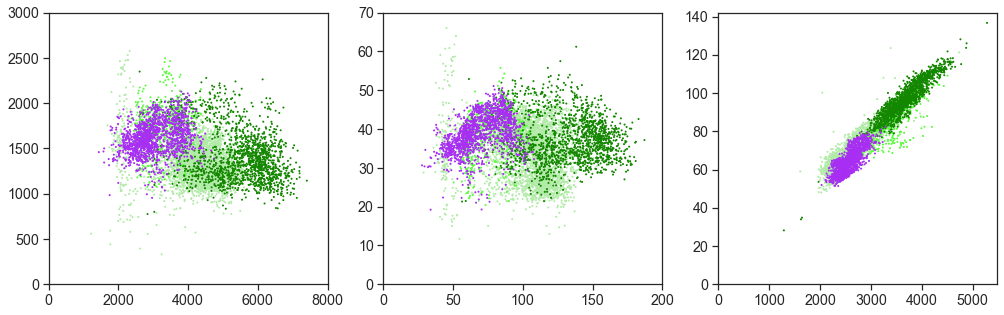

In [19]:
col_counts = xr.concat(layer_infos.values(),dim='track').Counts#  / xr.concat(layer_infos.values(),dim='track').Thickness
col_thickness = xr.concat(layer_infos.values(),dim='track').Thickness

# get color map
map_colors = np.zeros(col_counts.track.size)
pos = np.cumsum([0]+[i.track.size for i in layer_infos.values()])
for j, k in enumerate(pos[:-1]):
    map_colors[slice(pos[j],pos[j+1])]=j
lut = dict(zip(np.unique(map_colors), color_dict.values()))
map_colors = np.vectorize(lut.get)(map_colors)

# without normalization

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
axs[0].scatter(col_counts.sel(layer='layer456').data,col_counts.sel(layer='layer12').data,s=1,c=map_colors)
axs[0].set_xlim([0,8000]); axs[0].set_ylim([0,3000])
print(stats.pearsonr(col_counts.sel(layer='layer456').data,col_counts.sel(layer='layer12').data))

axs[1].scatter(col_thickness.sel(layer='layer456').data,col_thickness.sel(layer='layer12').data,s=1,c=map_colors)
axs[1].set_xlim([0,200]); axs[1].set_ylim([0,70])
print(stats.pearsonr(col_thickness.sel(layer='layer456').data,col_thickness.sel(layer='layer12')))

axs[2].scatter(col_counts.sel(layer='layer3').data,col_thickness.sel(layer='layer3').data,s=1,c=map_colors)
axs[2].set_xlim(0); axs[2].set_ylim(0)
print(stats.pearsonr(col_counts.sel(layer='layer3').data,col_thickness.sel(layer='layer3')))
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig5/correlation_plots.svg')

## Test volume flux relationship

(0.33055525317494217, 2.052395091905527e-176)


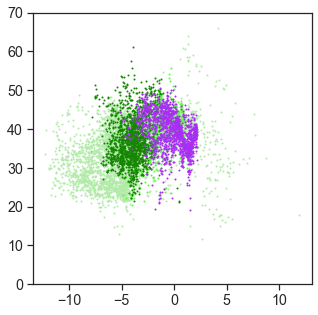

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
flux_l = []; counts_upper_l = []

for track_set in ['track_00','track_01','track_02','track_v2']: # 
    border_time = layer_infos[track_set].Positions.sel(layer='layer456',slice='stop').data
    reference_time = layer_infos[track_set].Positions.sel(layer='layer12',slice='stop').data 

    col_counts = layer_infos[track_set].Thickness # / (layer_infos[track_set].Thickness ** 2)
    col_counts_456 = col_counts.sel(layer=['layer456'])
    col_counts_upper = col_counts.sel(layer=['layer12'])# +col_counts.sel(layer=['layer3']).data

    lf = tracks[track_set].Local_flux
    dist = morphotrack.distance.position2distance_xr(tracks[track_set].Warped_position)

    flux = ((dist*lf).fillna(0)).sel(warped_time=slice(reference_time,border_time)).sum(dim='warped_time')
    # vol_raito = (col_counts_upper.data / col_counts_456.data).squeeze()

    # axs[0,0].scatter(lf.sel(warped_time=reference_time).data, vol_raito,s=1)
    # axs[0,1].scatter(lf.sel(warped_time=reference_time).data, flux,s=1)
    # axs[0,2].scatter(col_counts_456, col_counts_upper,s=1)
    # axs[1,0].scatter(lf.sel(warped_time=reference_time).data, col_counts_upper,s=1)
    # axs[1,1].scatter(lf.sel(warped_time=reference_time).data, col_counts_456,s=1)
    # axs[1,2].scatter(dist.sel(warped_time=slice(0,border_time)).sum(dim='warped_time'), col_counts_456,s=1) # no surprise
    # axs[1,3].scatter(dist.sel(warped_time=slice(0,border_time)).sum(dim='warped_time'), col_counts_upper,s=1)
    axs.scatter(flux, col_counts_upper,s=1,c=color_dict[track_set])
    # axs.scatter(lf.sel(warped_time=reference_time).data, col_counts_upper,s=1)
    axs.set_ylim(0,70)
    flux_l.append(flux.data.squeeze()); counts_upper_l.append(col_counts_upper.data.squeeze())
print(stats.pearsonr(np.hstack(flux_l), np.hstack(counts_upper_l)))
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig5/flux_upperthickness.svg')

### visualization of local flux and flux

-0.045105686352658415 0.01348071921299865


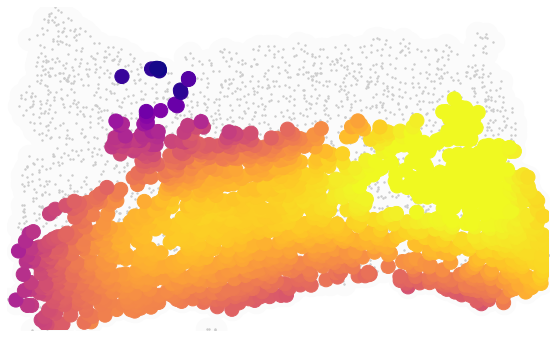

In [21]:
### local flux at layer 4
# in a flattened surface
track_set = 'track_v2'

# get values
X0 = tracks_original[track_set].Seeds.data
isomap = Isomap(n_neighbors=20, n_components=2, n_jobs=-1)
isomap.fit(X0)
manifold0 = isomap.transform(X0)
X1 = tracks[track_set].Seeds.data
manifold1 = isomap.transform(X1)

# local flux
pos_l4 = layer_infos[track_set].Positions.sel(layer='layer456',slice='start').data
val = tracks[track_set].Local_flux.sel(warped_time=pos_l4).copy()
val = val.data.squeeze()

# normalize for visualization
lfs = []
for tr in layer_infos.keys():
    pos_l4 = layer_infos[tr].Positions.sel(layer='layer456',slice='start').data
    lfs.append(tracks[tr].Local_flux.sel(warped_time=pos_l4).copy().data.squeeze())
lfs = np.hstack(lfs)
vmin = np.quantile(lfs,0.05)
vmax = np.quantile(lfs,0.95)
val[val<vmin] = vmin; val[val>vmax] = vmax

# plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(manifold0.max(axis=0) - manifold0.min(axis=0))/50)
ax.scatter(manifold0[:,0],manifold0[:,1],s=500, c='#fbfbfb')
ax.scatter(manifold0[:,0],manifold0[:,1],s=2, c='#cccccc')
ax.scatter(manifold1[:,0],manifold1[:,1],s=200,c=val,cmap='plasma')
ax.set_xlim([manifold0.min(axis=0)[0], manifold0.max(axis=0)[0]])
ax.set_ylim([manifold0.min(axis=0)[1], manifold0.max(axis=0)[1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
print(vmin, vmax)

-8.387663855273866 2.6588491085480466


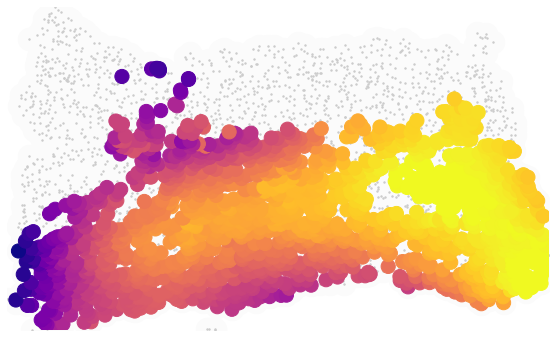

In [22]:
### flux along layers
# in a flattened surface
track_set = 'track_v2'

# get values
X0 = tracks_original[track_set].Seeds.data
isomap = Isomap(n_neighbors=20, n_components=2, n_jobs=-1)
isomap.fit(X0)
manifold0 = isomap.transform(X0)
X1 = tracks[track_set].Seeds.data
manifold1 = isomap.transform(X1)

# flux
border_time = layer_infos[track_set].Positions.sel(layer='layer456',slice='stop').data
reference_time = layer_infos[track_set].Positions.sel(layer='layer12',slice='start').data 
lf = tracks[track_set].Local_flux.copy()
dist = morphotrack.distance.position2distance_xr(tracks[track_set].Warped_position)
val = ((dist*lf).fillna(0)).sel(warped_time=slice(reference_time,border_time)).sum(dim='warped_time')

# normalize for visualization
fluxes = []
for tr in layer_infos.keys():
    border_time = layer_infos[tr].Positions.sel(layer='layer456',slice='stop').data
    reference_time = layer_infos[tr].Positions.sel(layer='layer12',slice='start').data 
    lf = tracks[tr].Local_flux.copy()
    dist = morphotrack.distance.position2distance_xr(tracks[tr].Warped_position)
    fluxes.append(((dist*lf).fillna(0)).sel(warped_time=slice(reference_time,border_time)).sum(dim='warped_time'))

fluxes = np.hstack(fluxes)
vmin = np.quantile(fluxes,0.05)
vmax = np.quantile(fluxes,0.95)
val[val<vmin] = vmin; val[val>vmax] = vmax

# plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(manifold0.max(axis=0) - manifold0.min(axis=0))/50)
ax.scatter(manifold0[:,0],manifold0[:,1],s=500, c='#fbfbfb')
ax.scatter(manifold0[:,0],manifold0[:,1],s=2, c='#cccccc')
ax.scatter(manifold1[:,0],manifold1[:,1],s=200,c=val,cmap='plasma')
ax.set_xlim([manifold0.min(axis=0)[0], manifold0.max(axis=0)[0]])
ax.set_ylim([manifold0.min(axis=0)[1], manifold0.max(axis=0)[1]])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
print(vmin, vmax)

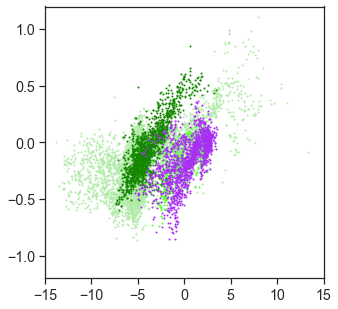

In [23]:
from sklearn.linear_model import LinearRegression
regs = []
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
fluxes = []; thick_diffs = []

for track_set in ['track_00','track_01','track_02','track_v2']: #['track_02']:# 
    border_time = layer_infos[track_set].Positions.sel(layer='layer456',slice='stop').data
    reference_time = layer_infos[track_set].Positions.sel(layer='layer12',slice='start').data 
    dist = morphotrack.distance.position2distance_xr(tracks[track_set].Warped_position)
    lf = tracks[track_set].Local_flux.copy()
    # lf = lf.fillna(-0.01).data.T
    # np.random.shuffle(lf)
    
    flux = ((dist*lf).fillna(0)).sel(warped_time=slice(reference_time,border_time)).sum(dim='warped_time')
    # std_track = tracks[track_set].Standard.attrs['standard_seed']
    
    thickness_456 = layer_infos[track_set].Thickness.sel(layer=['layer456'])
    thickness_12 = layer_infos[track_set].Thickness.sel(layer=['layer12'])
    argmed = np.argsort(thickness_456.data.squeeze())[len(thickness_456.data.squeeze())//2]
    std_track = thickness_456.isel(track=argmed).track

    thickness_norm_456 = thickness_456 / thickness_456.sel(track=std_track)
    thickness_norm_12 = thickness_12 / thickness_12.sel(track=std_track)
    fluxes.append(flux.data); thick_diffs.append((thickness_norm_12.data - thickness_norm_456.data).squeeze())

    axs.scatter(flux, (thickness_norm_12.data - thickness_norm_456.data).squeeze(), s=1, c=color_dict[track_set])
    # axs[0,1].plot(flux)
    # axs[0,2].scatter(flux, -thickness_norm_456, s=1)
    # axs[0,3].scatter(thickness_456.squeeze(), thickness_12.squeeze(), s=1)
    # axs[1,0].scatter(flux, thickness_norm_12, s=1)
    # axs[1,1].plot(thickness_456.data)
    # const = 0.05
    # axs[1,2].scatter(flux*const+thickness_norm_456.data.squeeze(), thickness_norm_12, s=1)
    # axs[1,2].set_xlim([0, 1.5]);axs[1,2].set_ylim([0, 1.5])
    regs.append(LinearRegression().fit(flux.data[:,np.newaxis], (thickness_norm_12.data - thickness_norm_456.data)))
fluxes = np.hstack(fluxes)
thick_diffs = np.hstack(thick_diffs)
axs.set_xlim([-15, 15]); axs.set_ylim([-1.2, 1.2])
regs.append(LinearRegression().fit(fluxes[:,np.newaxis], thick_diffs[:,np.newaxis]))
# plt.savefig('/home/tmurakami/Dropbox (Dropbox @RU)/19_publications/Fig5/flux_normdiff_scatter.svg')

In [129]:
for i in range(4):
    print(regs[i].coef_,regs[i].intercept_)
print(stats.pearsonr(fluxes, thick_diffs))

[[0.04739021]] [0.03534964]
[[0.06768597]] [-0.16166056]
[[0.11440304]] [0.39018555]
[[0.046329]] [0.03731951]
(0.5935388188831965, 0.0)


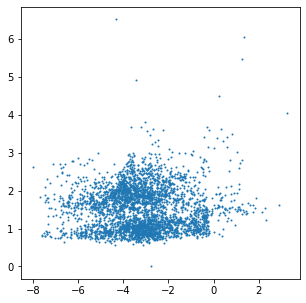

In [737]:
### For my eyes, it looks local thickness is very low quality and not useful...

track_set = 'track_00'
border_times = {'track_00':140,'track_01':220,'track_02':330}
reference_times = {'track_00':20,'track_01':50,'track_02':50} # {'track_00':0,'track_01':0,'track_02':0} # 

border_time = border_times[track_set]
# reference_time = reference_times[track_set]

dist = morphotrack.distance.position2distance_xr(tracks[track_set].Warped_position)
density = tracks[track_set].Total_warped.sel(displacement='t2s')
counts = dist * density.rename({'time':'warped_time'})

reference_time = 100
lf = tracks[track_set].Local_flux
flux = ((dist*lf).fillna(0)).sel(warped_time=slice(reference_time,border_time)).sum(dim='warped_time')
counts_ratio = counts.sel(warped_time=reference_time) / counts.sel(warped_time=slice(border_time-20,border_time)).mean(dim='warped_time')

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
axs.scatter(flux, counts_ratio, s=1)
# axs.set_ylim([0,3])

In [802]:
track_set = 'track_02'
viewer = napari.Viewer()
viewer.add_image(tracks[track_set].Local_flux.sel(warped_time=slice(0,border_times[track_set])))

<Image layer 'Image' at 0x7f6de5068e20>

## Density analysis

(0.0, 52.36539486756809)

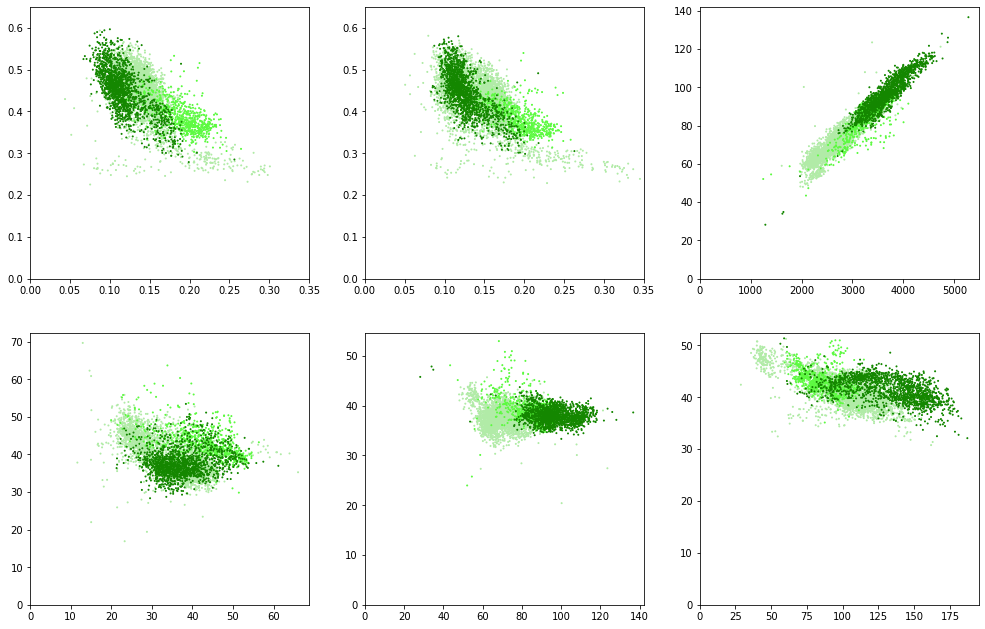

In [50]:
col_counts = xr.concat(layer_infos.values(),dim='track').Counts#  / xr.concat(layer_infos.values(),dim='track').Thickness
col_thickness = xr.concat(layer_infos.values(),dim='track').Thickness
col_inv_density = col_counts / col_thickness

# get color map
map_colors = np.zeros(col_counts.track.size)
pos = np.cumsum([0]+[i.track.size for i in layer_infos.values()])
for j, k in enumerate(pos[:-1]):
    map_colors[slice(pos[j],pos[j+1])]=j
lut = dict(zip(np.unique(map_colors), ['#b1eba7','#5dfa41','#148700']))
map_colors = np.vectorize(lut.get)(map_colors)

# normalization
norm_col_counts = col_counts / col_counts.sum(dim='layer')
norm_col_thickness = col_thickness / col_thickness.sum(dim='layer')

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(17,11))
axs[0,0].scatter(norm_col_counts.sel(layer='layer12').data,norm_col_counts.sel(layer='layer456').data,s=1,c=map_colors)
axs[0,0].set_xlim([0,0.35]); axs[0,0].set_ylim([0,0.65])

axs[0,1].scatter(norm_col_thickness.sel(layer='layer12').data,norm_col_thickness.sel(layer='layer456').data,s=1,c=map_colors)
axs[0,1].set_xlim([0,0.35]); axs[0,1].set_ylim([0,0.65])

# axs[0,2].scatter(col_counts.sel(layer='layer12').data,col_thickness.sel(layer='layer12').data,s=1,c='#fcba03')
axs[0,2].scatter(col_counts.sel(layer='layer3').data,col_thickness.sel(layer='layer3').data,s=1,c=map_colors)
# axs[0,2].scatter(col_counts.sel(layer='layer456').data,col_thickness.sel(layer='layer456').data,s=1,c='#7102f7')
axs[0,2].set_xlim(0); axs[0,2].set_ylim(0)

# axs[1,0].scatter(col_thickness.sel(layer='layer12').data,np.log10(col_inv_density.sel(layer='layer12').data),s=1,c=map_colors)
axs[1,0].scatter(col_thickness.sel(layer='layer12').data,col_inv_density.sel(layer='layer12').data,s=1,c=map_colors)
axs[1,0].set_xlim([0,None]); axs[1,0].set_ylim([0,None])

# axs[1,1].scatter(col_thickness.sel(layer='layer3').data,np.log10(col_inv_density.sel(layer='layer3').data),s=1,c=map_colors)
axs[1,1].scatter(col_thickness.sel(layer='layer3').data, col_inv_density.sel(layer='layer3').data,s=1,c=map_colors)
axs[1,1].set_xlim([0,None]); axs[1,1].set_ylim([0,None])

# axs[1,2].scatter(col_thickness.sel(layer='layer456').data,np.log10(col_inv_density.sel(layer='layer456').data),s=1,c=map_colors)
axs[1,2].scatter(col_thickness.sel(layer='layer456').data,col_inv_density.sel(layer='layer456').data,s=1,c=map_colors)
axs[1,2].set_xlim([0,None]); axs[1,2].set_ylim([0,None])

In [ ]:
track_set = 'track_00'
l = 'layer456'
reference_time = 100 # L4
tes = tracks[track_set]
lf = tes.Local_flux.sel(warped_time=reference_time).data
dens_tes = (layer_infos[track_set].Counts / layer_infos[track_set].Thickness).sel(layer=l).data

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
axs.scatter(lf, dens_tes, s=1, alpha=0.2)

track_set = 'track_01'
reference_time = 140 # L4
tes = tracks[track_set]
lf = tes.Local_flux.sel(warped_time=reference_time).data
dens_tes = (layer_infos[track_set].Counts / layer_infos[track_set].Thickness).sel(layer=l).data
axs.scatter(lf, dens_tes, s=1, alpha=0.2)

track_set = 'track_02'
reference_time = 180 # L4
tes = tracks[track_set]
lf = tes.Local_flux.sel(warped_time=reference_time).data
dens_tes = (layer_infos[track_set].Counts / layer_infos[track_set].Thickness).sel(layer=l).data
axs.scatter(lf, dens_tes, s=1, alpha=0.2)

# axs.set_ylim([0,None])
# axs.set_xlim([0,0.35]); 


In [ ]:
track_set = 'track_00'
reference_time = 100
tes = tracks[track_set]
lf = tes.Local_flux.sel(warped_time=reference_time).data
dens_tes = layer_infos[track_set].Thickness.sel(layer='layer456').data

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
axs.scatter(lf, dens_tes, s=1)

track_set = 'track_01'
reference_time = 140
tes = tracks[track_set]
lf = tes.Local_flux.sel(warped_time=reference_time).data
dens_tes = layer_infos[track_set].Thickness.sel(layer='layer456').data
axs.scatter(lf, dens_tes, s=1)

track_set = 'track_02'
reference_time = 180
tes = tracks[track_set]
lf = tes.Local_flux.sel(warped_time=reference_time).data
dens_tes = layer_infos[track_set].Thickness.sel(layer='layer456').data
axs.scatter(lf, dens_tes, s=1)

# axs.set_ylim([0,None])
# axs.set_xlim([0,0.35]); 


In [ ]:
col_counts = xr.concat(layer_fine_infos.values(),dim='track').Counts#  / xr.concat(layer_infos.values(),dim='track').Thickness
col_thickness = xr.concat(layer_fine_infos.values(),dim='track').Thickness
col_inv_density = col_thickness / col_counts

# get color map
map_colors = np.zeros(col_counts.track.size)
pos = np.cumsum([0]+[i.track.size for i in layer_infos.values()])
for j, k in enumerate(pos[:-1]):
    map_colors[slice(pos[j],pos[j+1])]=j
lut = dict(zip(np.unique(map_colors), ['#b1eba7','#5dfa41','#148700']))
map_colors = np.vectorize(lut.get)(map_colors)

# normalization
norm_col_counts = col_counts / col_counts.sum(dim='layer')
norm_col_thickness = col_thickness / col_thickness.sum(dim='layer')

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(17,11))

axs[0,0].scatter(col_counts.sel(layer='layer2').data,col_thickness.sel(layer='layer2').data,s=1,c=map_colors)
axs[0,0].set_xlim([0,None]); axs[0,0].set_ylim([0,None])
axs[0,1].scatter(col_counts.sel(layer='layer3').data,col_thickness.sel(layer='layer3').data,s=1,c=map_colors)
axs[0,1].set_xlim([0,None]); axs[0,1].set_ylim([0,None])
axs[0,2].scatter(col_counts.sel(layer='layer56').data,col_thickness.sel(layer='layer56').data,s=1,c=map_colors)
axs[0,2].set_xlim([0,None]); axs[0,2].set_ylim([0,None])